https://youtu.be/oBIkr7CAE6g

Binary semantic segmentation using U-Net
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob

In [3]:
image_directory = '/Users/ahmednourachiche/Desktop/ML/data/training/images'
gt_directory = '/Users/ahmednourachiche/Desktop/ML/data/training/groundtruth'
SIZE = 608

In [4]:
# store train RGB images
image_names = glob.glob(image_directory + '/*.png')
image_names.sort()
#images = [cv2.imread(img) for img in image_names]
images = [cv2.resize(cv2.imread(img),(SIZE,SIZE)) for img in image_names]
image_dataset = np.array(images)


In [5]:
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
gt_names.sort()
#gt = [cv2.imread(gt,0) for gt in gt_names]
gt = [cv2.resize(cv2.imread(gt,0),(SIZE,SIZE)) for gt in gt_names]
gt_dataset = np.array(gt)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [6]:
print("Image data shape is: ", image_dataset.shape)
print("gt data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 608, 608, 3)
gt data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 2

In [7]:
# binary labels
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
gt_names.sort()
# resize and define binary threshold
gt_dataset = []
for gt in gt_names:
    gt_img = cv2.imread(gt,0)
    gt_img = cv2.resize(gt_img,(SIZE,SIZE))
    _,gt_img = cv2.threshold(gt_img, 120, 255, cv2.THRESH_BINARY_INV)
    gt_dataset.append(gt_img)

gt_dataset = np.array(gt_dataset)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [8]:
print("Image data shape is: ", image_dataset.shape)
print("get data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset, return_counts=True)[0])
print("Classe weights are  : ", np.unique(gt_dataset, return_counts=True)[1] / np.sum(np.unique(gt_dataset, return_counts=True)[1]) )

Image data shape is:  (100, 608, 608, 3)
get data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]
Classe weights are  :  [0.20084609 0.79915391]


In [9]:
#test_image_data=scaler.fit_transform(image_dataset_uint8.reshape(-1, image_dataset_uint8.shape[-1])).reshape(image_dataset_uint8.shape)

In [10]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
gt_dataset = gt_dataset /255.  #PIxel values will be 0 or 1

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, gt_dataset, test_size = 0.20,random_state=0)


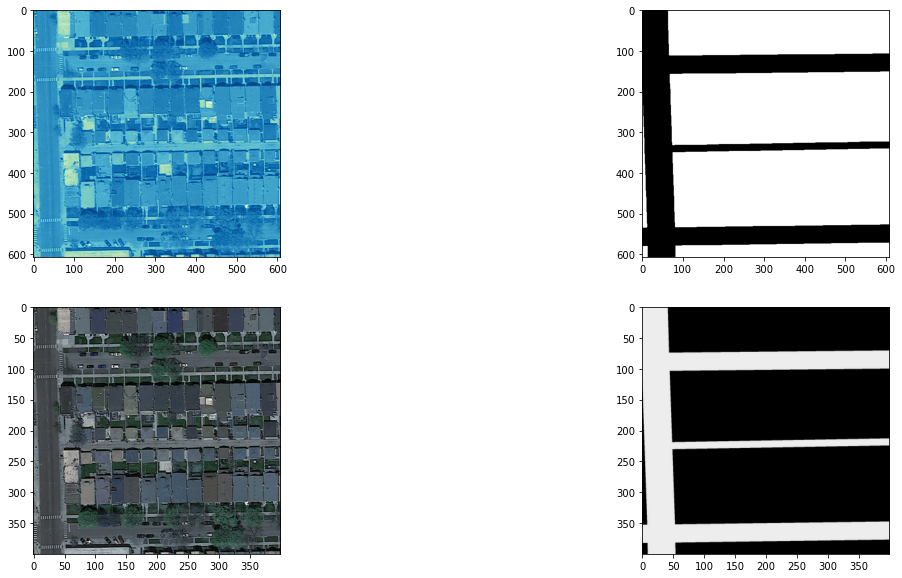

In [12]:
#Sanity check
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(image_dataset[image_number,:,:,0],cmap='GnBu_r')
plt.subplot(222)
plt.imshow(gt_dataset[image_number,:,:,0], cmap='gray')
plt.subplot(223)
plt.imshow(cv2.imread(image_names[image_number]))
plt.subplot(224)
plt.imshow(cv2.imread(gt_names[image_number]))
plt.show()



In [13]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [14]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## First model

In [15]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])


Metal device set to: Apple M1 Pro


2021-12-07 10:46:13.862176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-07 10:46:13.862318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


sigmoid


In [16]:
fit = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


2021-12-07 10:46:18.871689: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2021-12-07 10:46:19.444110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 1:37 - loss: 0.8437 - accuracy: 0.4578 - f1_m: 0.5101

KeyboardInterrupt: 

In [16]:
#Save the model for future use
model.save('first_model.h5')

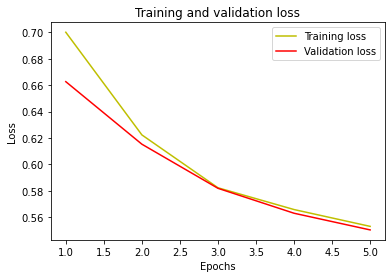

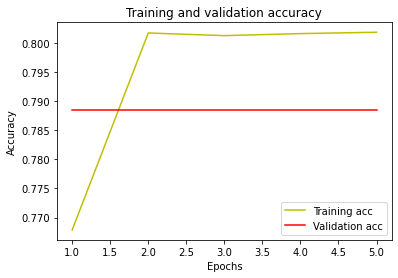

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## second model

In [16]:
import keras_unet_collection as kuc
from keras_unet_collection import models
from keras_unet_collection.losses import focal_tversky


In [17]:

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint("model.best.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1)
stop = EarlyStopping(monitor="val_accuracy", patience=3)
callbacklist = [checkpoint, reduce_lr, stop]


In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer='Adam', loss=focal_tversky, metrics=['accuracy'])

In [ ]:


# fit model
fit = model.fit(
   x=X_train,
   y=y_train,
   batch_size=8,
   epochs=25,
   validation_data=(X_test, y_test),
   callbacks=callbacklist,
)

2021-12-07 11:59:46.229541: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25


2021-12-07 11:59:46.777614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## loading and testing

In [24]:
#Load previously saved model
from keras.models import load_model
model = load_model('model.best.h5', compile=False)

In [16]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5775

NameError: name 'model' is not defined

In [17]:
f1_m(y_test,y_pred_thresholded)

NameError: name 'y_pred_thresholded' is not defined

In [26]:
from tensorflow.keras.metrics import MeanIoU

In [27]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.3942238


(1, 608, 608, 3)
(608, 608)


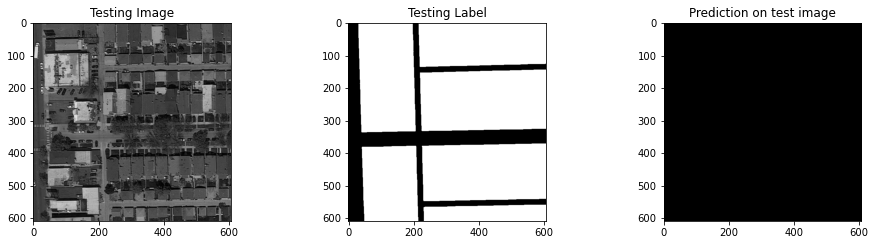

In [31]:
threshold = 0.5775
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] ).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()